In [11]:
import keras
import os 
import sys
import time 
import warnings
import h5py
import argparse
import logging
import sklearn
import pickle
import numpy as np
import pandas as pd
import keras_resnet.models
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img


from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications
from keras.optimizers import Adam
from keras.datasets import mnist

from sklearn.model_selection import train_test_split as splitter
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import svm


%matplotlib inline
warnings.simplefilter("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


/home/sanjay/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sanjay/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [12]:

class DataLoader(object):

    def __init__(self):

        self.image_dir = os.sep+'images'+os.sep
        self.labels = os.sep+'labels'+os.sep+'category_GT.mat'
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.train_data = None
        self.train_labels = None

    def labelLoader(self):

        mat_contents = sio.loadmat(os.getcwd() + self.labels)['GT']
        self.train_labels=np.array(mat_contents)


        file_list = [f for f in os.listdir(os.getcwd() 
            + self.image_dir) if os.path.isfile(os.path.join(
                os.getcwd() + self.image_dir, f))]
        file_list.sort()
        inputShape = (224, 224)
        img_list =[]

        for file in file_list:
            temp = os.getcwd() + self.image_dir + "/" + file
            #print filename

            #print("[INFO] loading and pre-processing image...")
            image = load_img(temp, target_size=inputShape)
            #print (image.size)
            image = img_to_array(image)
            pos = int(file.split(".")[0])
            img_list.insert(pos -1 , image)

        self.train_data = np.array(img_list)
        self.train_data /= 255 # normalizing pixel intensities


    def dropData(self,inputs,labels):
        self.train_data = inputs[np.isfinite(np.ravel(labels))]
        self.train_labels = labels[np.isfinite(labels)]

    def calls(self):

        self.labelLoader()
        self.dropData(self.train_data,self.train_labels)
        self.x_train,self.x_test,self.y_train,self.y_test = splitter(self.train_data,self.train_labels,
                                            test_size = 0.33,
                                            random_state = 14,#to get reproducible splits
                                            shuffle = True)
        print('Training Data:{}\
            Validation Data:{}'.format(self.x_train.shape,self.x_test.shape))

    def plot_first_n_images(self,img_list=None,n=9):

        if not img_list:
            img_list = self.train_data
        plt.figure(figsize = (10,10))

        for i in range(0, n):
            plt.subplot(330 + 1 + i)
            plt.imshow(img_list[i])
        plt.show()

In [25]:
class Augmentation(object):

    def __init__(self,data_object = None,model = 'ResNet50'):

        if not data_object:
            print('Calling data class form augmentation class')
            self.data_object = DataLoader()
            self.data_object.calls()

        self.model = str(model)

    def save_bottleneck_features(self, 
                filename = None,
                train = True):
        model = self.model
        if train:
            train_data_filter = self.data_object.x_train
            train_labels_filter = self.data_object.y_train
            filename = str('bottleneck_features_train'+str(model)+'.npy')
        else:
            train_data_filter = self.data_object.x_test
            train_labels_filter = self.data_object.y_test
            filename = str('bottleneck_features_test'+str(model)+'.npy')

        train_data_aug=[]
        train_labels_aug=[]
        batch_size = 128
        datagen = ImageDataGenerator(featurewise_center=True,
                                     featurewise_std_normalization=True,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

        if model == 'InceptionResNetV2':
            model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                         weights='imagenet')

        elif model == 'ResNet50':
            model = keras.applications.resnet50.ResNet50(include_top=False, 
                                                         weights='imagenet')


        elif model == 'Xception':
            keras.applications.xception.Xception(include_top=False,
                                         weights='imagenet')

        elif model == 'VGG16':
            model = keras.applications.vgg16.VGG16(include_top=False,
                                         weights='imagenet')

        elif model == 'VGG19':
            model = keras.applications.vgg19.VGG19(include_top=False,
                                         weights='imagenet')

        elif model == 'InceptionV3':
            model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                         weights='imagenet')

        elif model == 'DenseNet':
            model = keras.applications.densenet.DenseNet201(include_top=False,
                                         weights='imagenet')
        else:
            print('{} not implemented yet!'.format(model))

        print("loading gen on training data")

        datagen.fit(train_data_filter)

        print("generating augmentations of data")
        bottleneck_features_train =[]

        i = 0
        print("Total iterations = {}".format((1+len(train_data_filter) * 10)//batch_size))
        if os.path.isfile('models'+os.sep+'_'+filename):
            print('Skipping {}, features already saved'.format(self.model))
        for X_batch, y_batch in datagen.flow(train_data_filter, 
                                             train_labels_filter, 
                                             batch_size=batch_size, 
                                             shuffle=False):

            train_data_aug.extend(X_batch)
            train_labels_aug.extend(y_batch)

            #print("in iter ", i)

            #print("generating bottleneck features")
            bottleneck_features_train_batch = model.predict(
            X_batch,  verbose = 0)

            #print('\nBottleneck feature shape:{}'.format(bottleneck_features_train_batch.shape))


            bottleneck_features_train.extend(bottleneck_features_train_batch)
            i += 1

            if i > (len(train_data_filter) * 10)//batch_size:
                break

        bottleneck_features_train = np.array(bottleneck_features_train)
        train_data_aug = np.array(train_data_aug)
        train_labels_aug = np.array(train_labels_aug)
        print('\n_________________\nData Shapes\n_________________\n')
        print('\nBottleneck features:{}'.format(bottleneck_features_train.shape))
        print('\nAugmented Data:{}'.format(train_data_aug.shape))
        print('\nTrain labels:{}'.format(train_labels_aug.shape ))
        print("\nsaving bottleneck features to a file\n")
        if not os.path.isfile('models'+os.sep+'_'+filename):
            np.save(open(str('models'+os.sep+'_'+filename), 'wb'),
                bottleneck_features_train)

        return train_data_aug, train_labels_aug, bottleneck_features_train

In [34]:
class predictors(object):

    def __init__(self,load = True, model='ResNet50',
        x_eval = None,
        y_eval = None):
        self.model = model

    @staticmethod
    def accuracy(matrix):
        return (np.trace(matrix)) * 1.0 / np.sum(matrix)

    @staticmethod
    def pca(train_data_flat, num_features):
            pca = PCA(n_components = num_features)
            pca.fit(train_data_flat)
            train_data_flat_pca = pca.transform(train_data_flat)
            print(train_data_flat_pca.shape)
            return train_data_flat_pca	

    @staticmethod
    def eval_metrics(clf, x_eval=None  ,y_eval = None ):
        pred = clf.predict(x_eval)
        print(confusion_matrix(y_eval, pred))
        print(predictors.accuracy(confusion_matrix(y_eval, pred)))
        print(f1_score(y_eval, pred, average= 'micro'))
        print(f1_score(y_eval, pred, average= 'macro'))
        print(f1_score(y_eval, pred, average= 'weighted'))

    @staticmethod
    def lr(train_data, label):
            print('Logistic Regression\n')
            logistic_clf = linear_model.LogisticRegression(penalty="l2", 
                class_weight="balanced", 
                max_iter=100, verbose=1)
            logistic_clf.fit(train_data, label)
            return logistic_clf
    @staticmethod
    def svm(train_data, train_labels_augmented):
            svc = svm.SVC(C=0.5, kernel='linear')
            param_grid = [
                        {'C': [0.5, 1, 5], 'kernel': ['linear']},
                        {'C': [0.1, 1, 5], 'gamma': [0.001], 'kernel': ['rbf']},
                     ]
            kernel = ['linear', 'rbf']
            Cs = [0.1, 0.3, 1]    
            clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, n_jobs=-1,)
            clf.fit(train_data, train_labels_augmented)
            print('___________')
            print('\nSVM:\n')
            print(clf.best_score_)
            print(clf.best_estimator_.C)
            print(clf.best_estimator_.kernel)
            print(clf.best_params_)
    @staticmethod
    def svm_best(train_data, label):
        from sklearn import svm
        clf = svm.SVC(C=5, kernel='rbf', gamma = 0.001)
        clf.fit(train_data, label)
        return clf
    
    @staticmethod
    def random_forest(X, y,x_eval = None, y_eval = None):
            print('\nRandom Forest\n')
            k_fold = 10
            kf_total = KFold(n_splits=k_fold)
            forest = RandomForestClassifier(n_estimators=250,
                                            random_state=0)
            #estimators_list = [50, 100, 150, 250, 500, 800, 1000]  
            estimators_list = [50, 150, 500]  
            clf_forest = GridSearchCV(estimator=forest, 
                param_grid=dict(n_estimators=estimators_list, 
                    warm_start=[True, False]), 
                cv=k_fold, n_jobs=2)
            cms = [confusion_matrix(y_eval, 
                clf_forest.fit(X,y).predict(x_eval)) for train, test in kf_total.split(X)]
            accuracies = []
            for cm in cms:
                    accuracies.append(accuracy(cm))
            print(accuracies)
            print(np.mean(accuracies))
    
    @staticmethod
    def calls(train_data_flat_pca,train_labels_aug,x_eval = None,y_eval = None):

        clf = predictors.lr(train_data_flat_pca, train_labels_aug)
        predictors.eval_metrics(clf,x_eval = x_eval, y_eval = y_eval)
        #cv_results_ = predictors.svm(train_data_flat_pca, train_labels_aug)
        # gridsearch SVM later
        clf = predictors.svm_best(train_data_flat_pca, train_labels_aug)
        predictors.eval_metrics(clf,x_eval = x_eval, y_eval = y_eval)
        #predictors.random_forest(train_data_flat_pca, train_labels_aug,x_eval = x_eval, y_eval = y_eval)


Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)


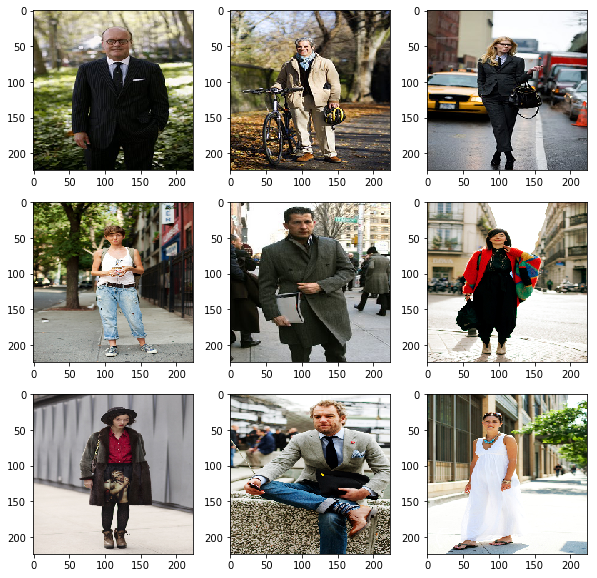

loading gen on training data
generating augmentations of data
Total iterations = 57
Skipping ResNet50, features already saved
in iter  0
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  1
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  2
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  3
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  4
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  5
generating bottleneck features

Bottleneck feature shape:(99, 1, 1, 2048)
in iter  6
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  7
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  8
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  9
generating bottleneck features

Bottleneck feature shape:(128, 1, 1, 2048)
in iter  10
gen

In [15]:
augmenter = Augmentation(model = 'ResNet50')
augmenter.data_object.plot_first_n_images()
train_data_aug, train_labels_aug, bottleneck_features_train = augmenter.save_bottleneck_features(
    train = True)
test_data_aug, test_labels_aug, bottleneck_features_test = augmenter.save_bottleneck_features(
    train = False)

In [28]:
def flatten(array):#move this to class as static method?
    return predictors.pca(np.reshape(array,(array.shape[0],-1)),1000)

In [29]:
train_data_flat_pca = flatten(bottleneck_features_train)
test_data_flat_pca = flatten(bottleneck_features_test)

(7163, 1000)
(3541, 1000)


In [35]:
predictors.calls(train_data_flat_pca,train_labels_aug,
        x_eval = test_data_flat_pca,
        y_eval = test_labels_aug)

Logistic Regression

[LibLinear][[ 61  46  69  96  88  28  84]
 [ 24  18  31  31  54   4  89]
 [ 31  39  51 134  67  23  60]
 [ 69  11  85 108  88  14 258]
 [ 50  81  72 172 172  33 159]
 [ 52  18  14  48  71  18  17]
 [109  63  84 165 178  25 179]]
0.171420502683
0.171420502683
0.148223467107
0.170625419745
[[ 44  21  53 145  95   0 114]
 [ 29  15  14  48  47   1  97]
 [ 40  33  65 151  65   0  51]
 [ 68   7  57 120 142   0 239]
 [ 58   0  67 225 206   0 183]
 [ 49   0  14  53  97   0  25]
 [137  18  49 191 235   6 167]]
0.174244563683
0.174244563683
0.138598071235
0.165166015608


In [36]:
del augmenter,train_data_flat_pca,test_data_flat_pca

In [37]:
def test(model):
    print(model)
    augmenter = Augmentation(model = model)
    train_data_aug, train_labels_aug, bottleneck_features_train = augmenter.save_bottleneck_features(
        train = True)
    test_data_aug, test_labels_aug, bottleneck_features_test = augmenter.save_bottleneck_features(
        train = False)
    train_data_flat_pca = flatten(bottleneck_features_train)
    test_data_flat_pca = flatten(bottleneck_features_test)
    predictors.calls(train_data_flat_pca,train_labels_aug,
        x_eval = test_data_flat_pca,
        y_eval = test_labels_aug)
    del augmenter,train_data_flat_pca,test_data_flat_pca

In [38]:
test('VGG19')

VGG19
Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)
80101376/80134624 [============================>.] - ETA: 0sloading gen on training data
generating augmentations of data
Total iterations = 57

_________________
Data Shapes
_________________


Bottleneck features:(7163, 7, 7, 512)

Augmented Data:(7163, 224, 224, 3)

Train labels:(7163,)

saving bottleneck features to a file

loading gen on training data
generating augmentations of data
Total iterations = 28

_________________
Data Shapes
_________________


Bottleneck features:(3541, 7, 7, 512)

Augmented Data:(3541, 224, 224, 3)

Train labels:(3541,)

saving bottleneck features to a file

(7163, 1000)
(3541, 1000)
Logistic Regression

[LibLinear][[ 29  15  84  97 130  22  95]
 [ 15   3  40  70  36   3  84]
 [ 10   8 221  38  11   0 117]
 [ 42  28  92 183 139  18 131]
 [ 68  25  55 134 321  15 121]
 [ 21  14  90  42  18   0  53]
 [ 56  29 107  82 118  11 40

In [39]:
test('VGG16')

VGG16
Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)
58892288/58889256 [==============================] - 22s    
loading gen on training data
generating augmentations of data
Total iterations = 57

_________________
Data Shapes
_________________


Bottleneck features:(7163, 7, 7, 512)

Augmented Data:(7163, 224, 224, 3)

Train labels:(7163,)

saving bottleneck features to a file

loading gen on training data
generating augmentations of data
Total iterations = 28

_________________
Data Shapes
_________________


Bottleneck features:(3541, 7, 7, 512)

Augmented Data:(3541, 224, 224, 3)

Train labels:(3541,)

saving bottleneck features to a file

(7163, 1000)
(3541, 1000)
Logistic Regression

[LibLinear][[ 35  10 130  81 139   4  73]
 [ 11  17  63  33  80   0  47]
 [  6  15  26   7  29  17 305]
 [ 60  36  78 150 215   9  85]
 [ 85  64 104 193 210   9  74]
 [ 16  14  62  27  36   7  76]
 [ 42  29 385 103  42  18 1

In [40]:
test('Xception')

Xception
Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)
83542016/83683744 [============================>.] - ETA: 0sloading gen on training data
generating augmentations of data
Total iterations = 57


AttributeError: 'str' object has no attribute 'predict'

In [41]:
test('InceptionV3')

InceptionV3
Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)
87834624/87910968 [============================>.] - ETA: 0sloading gen on training data
generating augmentations of data
Total iterations = 57

_________________
Data Shapes
_________________


Bottleneck features:(7163, 5, 5, 2048)

Augmented Data:(7163, 224, 224, 3)

Train labels:(7163,)

saving bottleneck features to a file

loading gen on training data
generating augmentations of data
Total iterations = 28

_________________
Data Shapes
_________________


Bottleneck features:(3541, 5, 5, 2048)

Augmented Data:(3541, 224, 224, 3)

Train labels:(3541,)

saving bottleneck features to a file

(7163, 1000)
(3541, 1000)
Logistic Regression

[LibLinear][[ 73  34 167  75  40  23  60]
 [ 79  13  56  47  40   4  12]
 [ 64  41 223  24   5  18  30]
 [ 85  64  72 163 122  15 112]
 [ 33  37 109 141 386   5  28]
 [ 45  12  92  23  20  11  35]
 [127  54 163 121  3

In [42]:
test('DenseNet')

DenseNet
Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)


AttributeError: module 'keras.applications' has no attribute 'densenet'

In [43]:
test('InceptionResNetV2')

InceptionResNetV2
Calling data class form augmentation class
Training Data:(739, 224, 224, 3)            Validation Data:(365, 224, 224, 3)


AttributeError: module 'keras.applications' has no attribute 'inception_resnet_v2'